In [1]:
# Fuel Cell Performance Prediction - Deep Analysis
# This notebook provides extended analysis of the fuel cell performance prediction project

# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
from sklearn.inspection import partial_dependence
import scipy.stats as stats

# Set plotting style
plt.style.use('default')
sns.set_palette("deep")
%matplotlib inline

# Load the generated data
print("Loading data...")
data = pd.read_csv('../data/synthetic_data.csv')
print(f"Data shape: {data.shape}")
print("\nFirst 5 rows:")
display(data.head())

# Load trained models
print("\nLoading trained models...")
lr_model = joblib.load('../models/trained_linear_model.pkl')
nn_model = joblib.load('../models/trained_nn_model.pkl')

# Load the test data (we'll need to regenerate this to match training)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Prepare data as was done in training
X = data[['Current_Density_A_cm2', 'Temperature_K']]
y = data['Cell_Voltage_V']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Make predictions
lr_pred = lr_model.predict(X_test)
nn_pred = nn_model.predict(X_test_scaled)

print("Data and models loaded successfully!")

Loading data...
Data shape: (2000, 3)

First 5 rows:


,Current_Density_A_cm2,Temperature_K,Cell_Voltage_V
0,0.561810,318.702341,1.285157
1,1.426071,317.818728,0.449132
2,1.097991,357.375275,0.947224
3,0.897988,317.972772,0.912518
4,0.234028,319.316984,1.782595



Loading trained models...
Data and models loaded successfully!


Statistical Summary of Dataset:


,Current_Density_A_cm2,Temperature_K,Cell_Voltage_V
count,2000.000000,2000.000000,2000.000000
mean,0.747955,332.783423,1.273470
std,0.438316,17.314794,0.632414
min,0.004827,303.000698,0.275568
25%,0.357070,318.047206,0.792787
50%,0.761027,332.561660,1.140209
75%,1.126018,347.921431,1.634626
max,1.499577,362.973462,3.859394


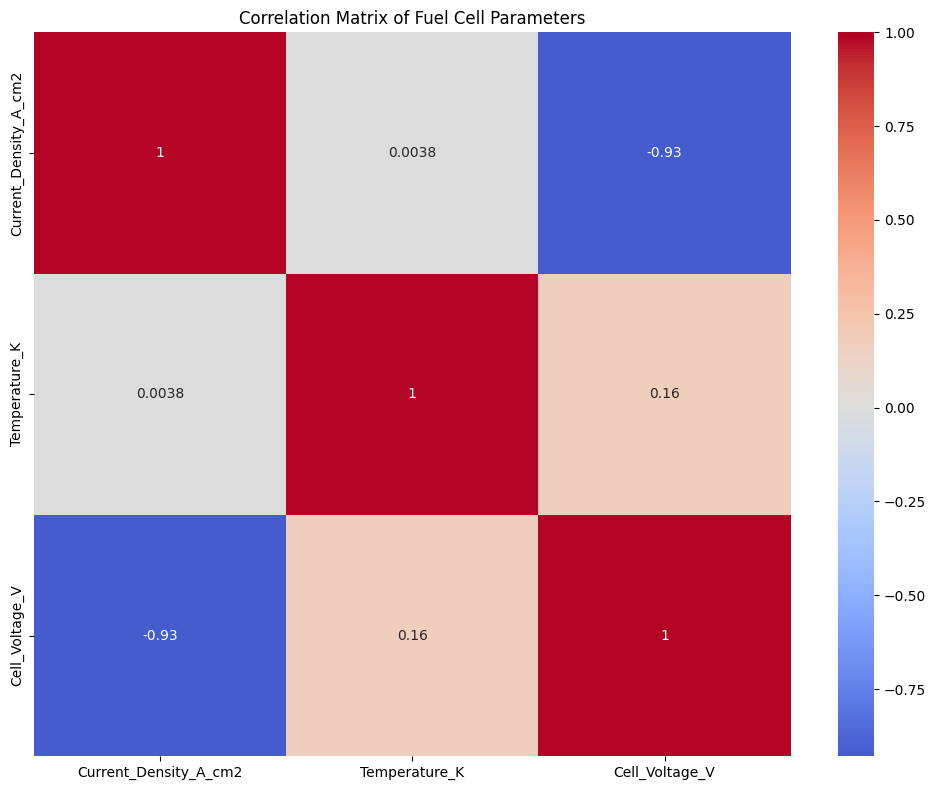

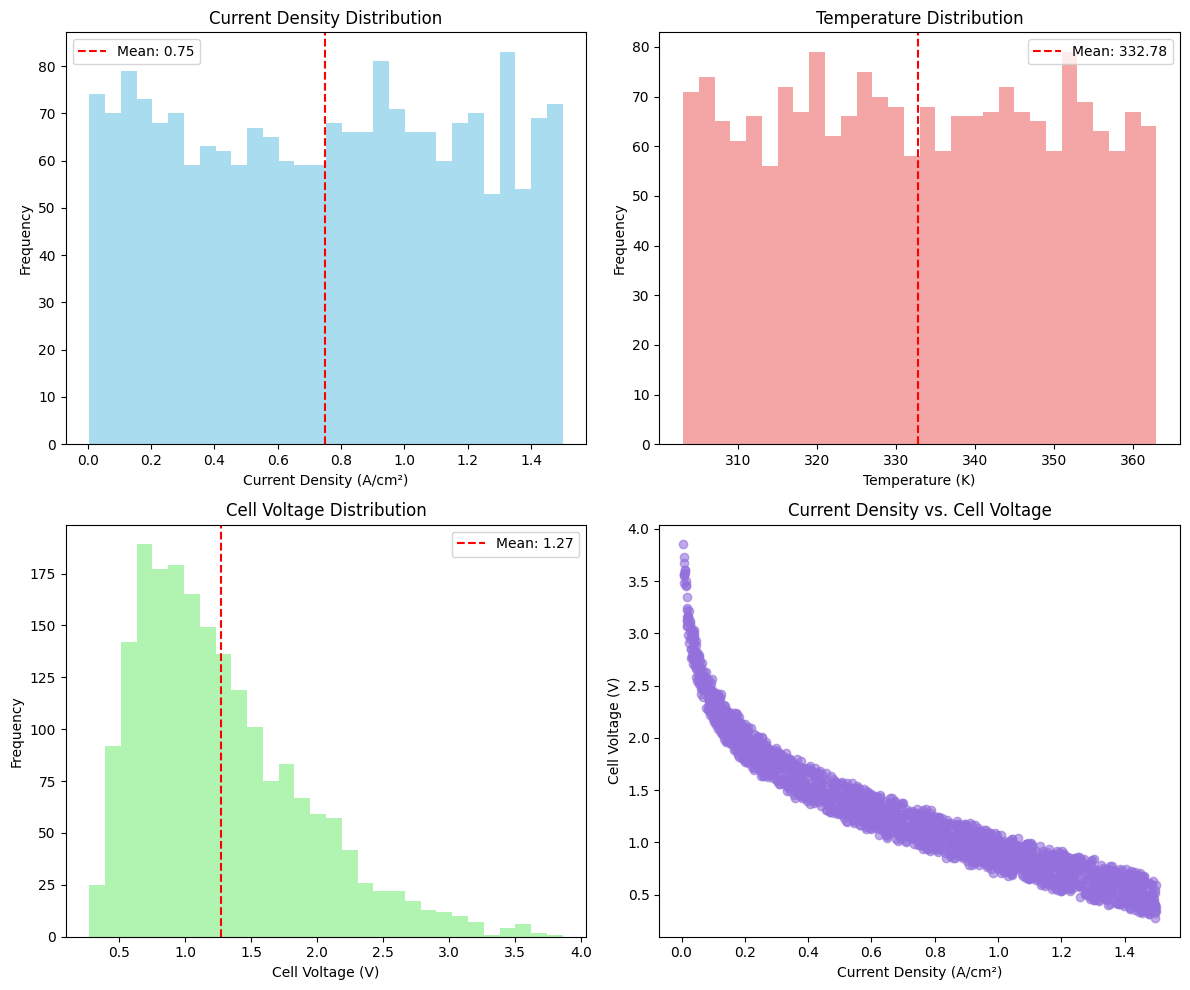

In [2]:
# 1.1 Statistical Summary
print("Statistical Summary of Dataset:")
display(data.describe())

# 1.2 Correlation Analysis
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Fuel Cell Parameters')
plt.tight_layout()
plt.show()

# 1.3 Distribution Plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Current Density Distribution
axes[0, 0].hist(data['Current_Density_A_cm2'], bins=30, alpha=0.7, color='skyblue')
axes[0, 0].set_xlabel('Current Density (A/cm²)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Current Density Distribution')
axes[0, 0].axvline(data['Current_Density_A_cm2'].mean(), color='red', linestyle='--', label=f'Mean: {data["Current_Density_A_cm2"].mean():.2f}')
axes[0, 0].legend()

# Temperature Distribution
axes[0, 1].hist(data['Temperature_K'], bins=30, alpha=0.7, color='lightcoral')
axes[0, 1].set_xlabel('Temperature (K)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Temperature Distribution')
axes[0, 1].axvline(data['Temperature_K'].mean(), color='red', linestyle='--', label=f'Mean: {data["Temperature_K"].mean():.2f}')
axes[0, 1].legend()

# Voltage Distribution
axes[1, 0].hist(data['Cell_Voltage_V'], bins=30, alpha=0.7, color='lightgreen')
axes[1, 0].set_xlabel('Cell Voltage (V)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Cell Voltage Distribution')
axes[1, 0].axvline(data['Cell_Voltage_V'].mean(), color='red', linestyle='--', label=f'Mean: {data["Cell_Voltage_V"].mean():.2f}')
axes[1, 0].legend()

# Current Density vs Voltage
axes[1, 1].scatter(data['Current_Density_A_cm2'], data['Cell_Voltage_V'], alpha=0.6, color='mediumpurple')
axes[1, 1].set_xlabel('Current Density (A/cm²)')
axes[1, 1].set_ylabel('Cell Voltage (V)')
axes[1, 1].set_title('Current Density vs. Cell Voltage')

plt.tight_layout()
plt.show()

Model Performance Metrics:


,Model,MSE,RMSE,MAE,R²,Relative RMSE (%),Relative MAE (%)
0,Linear Regression,0.035473,0.188342,0.139561,0.908565,14.953035,11.080132
1,Neural Network,0.003344,0.057825,0.032803,0.991381,4.590924,2.604292


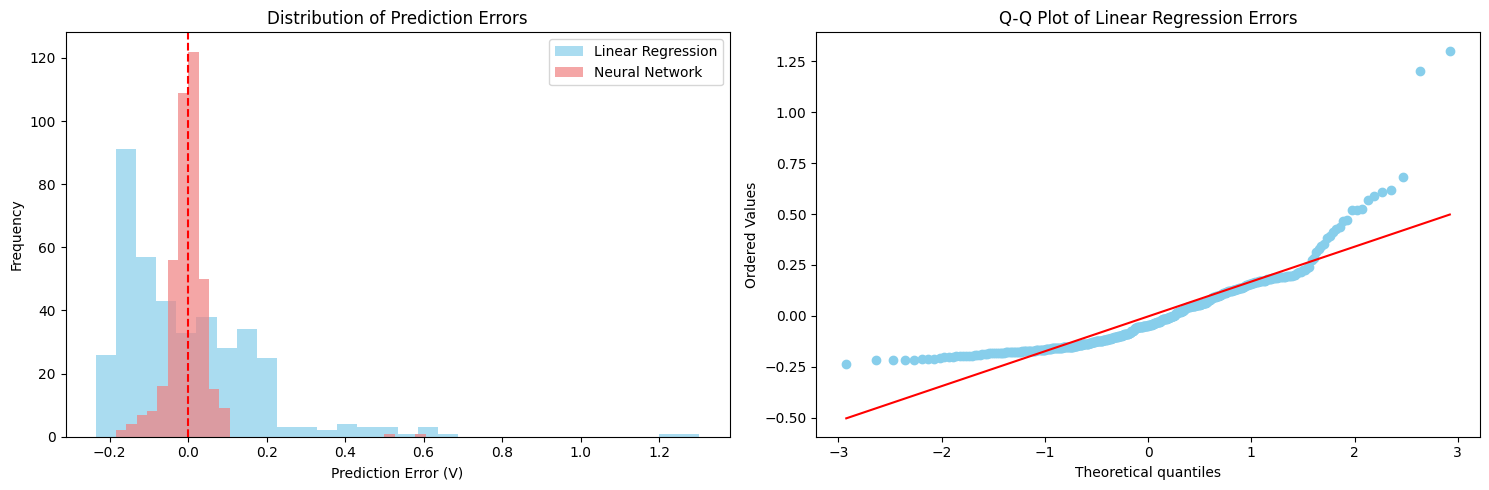

Error Analysis:
Linear Regression Error Mean: -0.003242 V
Neural Network Error Mean: -0.001679 V
Linear Regression Error Std: 0.188550 V
Neural Network Error Std: 0.057873 V

Paired t-test between model errors:
t-statistic: -0.1685, p-value: 8.6629e-01
The difference in errors is not statistically significant (p >= 0.05)


In [3]:
# 2.1 Comprehensive Model Evaluation
def calculate_metrics(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Calculate relative errors
    relative_rmse = rmse / np.mean(y_true) * 100
    relative_mae = mae / np.mean(y_true) * 100
    
    return {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'Relative RMSE (%)': relative_rmse,
        'Relative MAE (%)': relative_mae
    }

# Calculate metrics for both models
lr_metrics = calculate_metrics(y_test, lr_pred, 'Linear Regression')
nn_metrics = calculate_metrics(y_test, nn_pred, 'Neural Network')

# Create comparison dataframe
metrics_df = pd.DataFrame([lr_metrics, nn_metrics])
print("Model Performance Metrics:")
display(metrics_df)

# 2.2 Error Distribution Analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Error histograms
lr_errors = y_test - lr_pred
nn_errors = y_test - nn_pred

axes[0].hist(lr_errors, bins=30, alpha=0.7, color='skyblue', label='Linear Regression')
axes[0].hist(nn_errors, bins=30, alpha=0.7, color='lightcoral', label='Neural Network')
axes[0].axvline(0, color='red', linestyle='--')
axes[0].set_xlabel('Prediction Error (V)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Prediction Errors')
axes[0].legend()

# QQ plot for normality check
stats.probplot(lr_errors, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot of Linear Regression Errors')
axes[1].get_lines()[0].set_markerfacecolor('skyblue')
axes[1].get_lines()[0].set_markeredgecolor('skyblue')

plt.tight_layout()
plt.show()

# 2.3 Statistical tests for error differences
print("Error Analysis:")
print(f"Linear Regression Error Mean: {lr_errors.mean():.6f} V")
print(f"Neural Network Error Mean: {nn_errors.mean():.6f} V")
print(f"Linear Regression Error Std: {lr_errors.std():.6f} V")
print(f"Neural Network Error Std: {nn_errors.std():.6f} V")

# T-test to see if error means are significantly different
t_stat, p_value = stats.ttest_rel(lr_errors, nn_errors)
print(f"\nPaired t-test between model errors:")
print(f"t-statistic: {t_stat:.4f}, p-value: {p_value:.4e}")

if p_value < 0.05:
    print("The difference in errors is statistically significant (p < 0.05)")
else:
    print("The difference in errors is not statistically significant (p >= 0.05)")

Linear Regression Feature Importance:


,Feature,Coefficient,Absolute_Coefficient
0,Current_Density_A_cm2,-1.34781,1.34781
1,Temperature_K,0.00609,0.00609


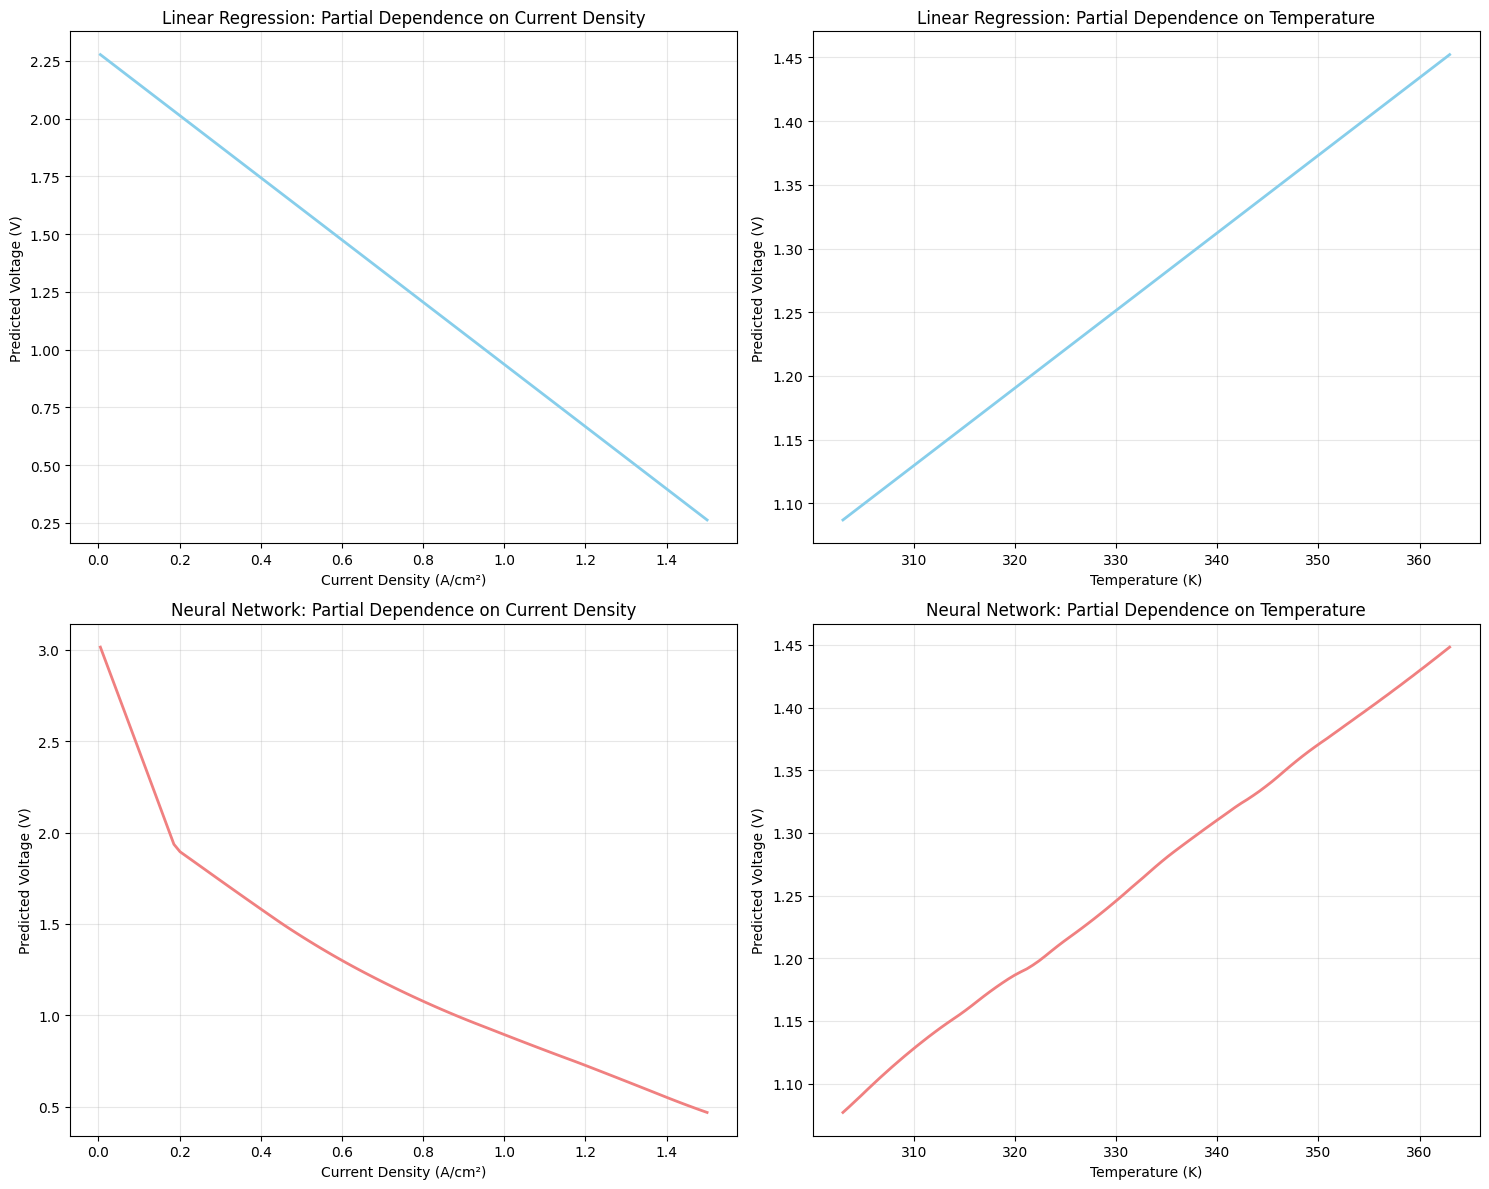

In [4]:
# 3.1 Feature Importance Analysis
# For linear regression
lr_coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_,
    'Absolute_Coefficient': np.abs(lr_model.coef_)
}).sort_values('Absolute_Coefficient', ascending=False)

print("Linear Regression Feature Importance:")
display(lr_coefficients)

# 3.2 Partial Dependence Plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Generate grid for partial dependence analysis
current_density_grid = np.linspace(X['Current_Density_A_cm2'].min(), X['Current_Density_A_cm2'].max(), 100)
temperature_grid = np.linspace(X['Temperature_K'].min(), X['Temperature_K'].max(), 100)

# Partial dependence for current density (Linear Regression)
lr_pd_current = []
for cd in current_density_grid:
    temp_df = pd.DataFrame({
        'Current_Density_A_cm2': [cd] * len(temperature_grid),
        'Temperature_K': temperature_grid
    })
    lr_pd_current.append(lr_model.predict(temp_df).mean())
    
axes[0, 0].plot(current_density_grid, lr_pd_current, color='skyblue', linewidth=2)
axes[0, 0].set_xlabel('Current Density (A/cm²)')
axes[0, 0].set_ylabel('Predicted Voltage (V)')
axes[0, 0].set_title('Linear Regression: Partial Dependence on Current Density')
axes[0, 0].grid(True, alpha=0.3)

# Partial dependence for temperature (Linear Regression)
lr_pd_temp = []
for temp in temperature_grid:
    temp_df = pd.DataFrame({
        'Current_Density_A_cm2': current_density_grid,
        'Temperature_K': [temp] * len(current_density_grid)
    })
    lr_pd_temp.append(lr_model.predict(temp_df).mean())
    
axes[0, 1].plot(temperature_grid, lr_pd_temp, color='skyblue', linewidth=2)
axes[0, 1].set_xlabel('Temperature (K)')
axes[0, 1].set_ylabel('Predicted Voltage (V)')
axes[0, 1].set_title('Linear Regression: Partial Dependence on Temperature')
axes[0, 1].grid(True, alpha=0.3)

# Partial dependence for current density (Neural Network)
nn_pd_current = []
for cd in current_density_grid:
    temp_df = pd.DataFrame({
        'Current_Density_A_cm2': [cd] * len(temperature_grid),
        'Temperature_K': temperature_grid
    })
    temp_scaled = scaler.transform(temp_df)
    nn_pd_current.append(nn_model.predict(temp_scaled).mean())
    
axes[1, 0].plot(current_density_grid, nn_pd_current, color='lightcoral', linewidth=2)
axes[1, 0].set_xlabel('Current Density (A/cm²)')
axes[1, 0].set_ylabel('Predicted Voltage (V)')
axes[1, 0].set_title('Neural Network: Partial Dependence on Current Density')
axes[1, 0].grid(True, alpha=0.3)

# Partial dependence for temperature (Neural Network)
nn_pd_temp = []
for temp in temperature_grid:
    temp_df = pd.DataFrame({
        'Current_Density_A_cm2': current_density_grid,
        'Temperature_K': [temp] * len(current_density_grid)
    })
    temp_scaled = scaler.transform(temp_df)
    nn_pd_temp.append(nn_model.predict(temp_scaled).mean())
    
axes[1, 1].plot(temperature_grid, nn_pd_temp, color='lightcoral', linewidth=2)
axes[1, 1].set_xlabel('Temperature (K)')
axes[1, 1].set_ylabel('Predicted Voltage (V)')
axes[1, 1].set_title('Neural Network: Partial Dependence on Temperature')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# 4.1 Performance by Current Density Range - FIXED VERSION
current_density_bins = pd.cut(X_test['Current_Density_A_cm2'], bins=5)

# Create DataFrames for grouping
test_df = pd.DataFrame({
    'actual': y_test,
    'lr_pred': lr_pred,
    'nn_pred': nn_pred,
    'cd_bin': current_density_bins
})

# Calculate metrics for Linear Regression
lr_performance_by_cd = test_df.groupby('cd_bin').apply(
    lambda x: pd.Series({
        'mean_actual': x['actual'].mean(),
        'std_actual': x['actual'].std(),
        'mean_pred': x['lr_pred'].mean(),
        'std_pred': x['lr_pred'].std(),
        'rmse': np.sqrt(((x['actual'] - x['lr_pred']) ** 2).mean())
    })
)

# Calculate metrics for Neural Network
nn_performance_by_cd = test_df.groupby('cd_bin').apply(
    lambda x: pd.Series({
        'mean_actual': x['actual'].mean(),
        'std_actual': x['actual'].std(),
        'mean_pred': x['nn_pred'].mean(),
        'std_pred': x['nn_pred'].std(),
        'rmse': np.sqrt(((x['actual'] - x['nn_pred']) ** 2).mean())
    })
)

print("Linear Regression Performance by Current Density Range:")
display(lr_performance_by_cd)

print("\nNeural Network Performance by Current Density Range:")
display(nn_performance_by_cd)

# 4.2 Performance by Temperature Range - FIXED VERSION
temperature_bins = pd.cut(X_test['Temperature_K'], bins=5)

# Add temperature bins to the DataFrame
test_df['temp_bin'] = temperature_bins

# Calculate metrics for Linear Regression
lr_performance_by_temp = test_df.groupby('temp_bin').apply(
    lambda x: pd.Series({
        'mean_actual': x['actual'].mean(),
        'std_actual': x['actual'].std(),
        'mean_pred': x['lr_pred'].mean(),
        'std_pred': x['lr_pred'].std(),
        'rmse': np.sqrt(((x['actual'] - x['lr_pred']) ** 2).mean())
    })
)

# Calculate metrics for Neural Network
nn_performance_by_temp = test_df.groupby('temp_bin').apply(
    lambda x: pd.Series({
        'mean_actual': x['actual'].mean(),
        'std_actual': x['actual'].std(),
        'mean_pred': x['nn_pred'].mean(),
        'std_pred': x['nn_pred'].std(),
        'rmse': np.sqrt(((x['actual'] - x['nn_pred']) ** 2).mean())
    })
)

print("Linear Regression Performance by Temperature Range:")
display(lr_performance_by_temp)

print("\nNeural Network Performance by Temperature Range:")
display(nn_performance_by_temp)

Linear Regression Performance by Current Density Range:


C:\Users\Maintenant prêt\AppData\Local\Temp\ipykernel_15396\3140464233.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lr_performance_by_cd = test_df.groupby('cd_bin').apply(
C:\Users\Maintenant prêt\AppData\Local\Temp\ipykernel_15396\3140464233.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lr_performance_by_cd = test_df.groupby('cd_bin').apply(
C:\Users\Maintenant prêt\AppData\Local\Temp\ipykernel_15396\3140464233.py:24: FutureWarning: The default of observed=False is deprecated and will be changed t

,mean_actual,std_actual,mean_pred,std_pred,rmse
cd_bin,,,,,
"(0.00715, 0.307]",2.206816,0.430491,2.076495,0.170839,0.317215
"(0.307, 0.605]",1.510466,0.178263,1.685324,0.174863,0.176515
"(0.605, 0.903]",1.160300,0.136411,1.294860,0.153165,0.139218
"(0.903, 1.201]",0.855540,0.154233,0.869009,0.182286,0.046419
"(1.201, 1.499]",0.594245,0.139068,0.460603,0.171123,0.143664



Neural Network Performance by Current Density Range:


,mean_actual,std_actual,mean_pred,std_pred,rmse
cd_bin,,,,,
"(0.00715, 0.307]",2.206816,0.430491,2.222073,0.419176,0.112562
"(0.307, 0.605]",1.510466,0.178263,1.517016,0.181985,0.033046
"(0.605, 0.903]",1.160300,0.136411,1.153671,0.140188,0.035040
"(0.903, 1.201]",0.855540,0.154233,0.849436,0.149361,0.023921
"(1.201, 1.499]",0.594245,0.139068,0.593720,0.142395,0.021851


Linear Regression Performance by Temperature Range:


C:\Users\Maintenant prêt\AppData\Local\Temp\ipykernel_15396\3140464233.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lr_performance_by_temp = test_df.groupby('temp_bin').apply(
C:\Users\Maintenant prêt\AppData\Local\Temp\ipykernel_15396\3140464233.py:47: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lr_performance_by_temp = test_df.groupby('temp_bin').apply(
C:\Users\Maintenant prêt\AppData\Local\Temp\ipykernel_15396\3140464233.py:58: FutureWarning: The default of observed=False is deprecated and will be c

,mean_actual,std_actual,mean_pred,std_pred,rmse
temp_bin,,,,,
"(303.17, 315.157]",1.050008,0.629302,1.028070,0.625009,0.166893
"(315.157, 327.085]",1.159223,0.553610,1.185543,0.571729,0.158477
"(327.085, 339.013]",1.252126,0.533960,1.292046,0.562340,0.149178
"(339.013, 350.941]",1.420240,0.622361,1.427206,0.588965,0.177449
"(350.941, 362.869]",1.383391,0.661652,1.366919,0.602924,0.245867



Neural Network Performance by Temperature Range:


,mean_actual,std_actual,mean_pred,std_pred,rmse
temp_bin,,,,,
"(303.17, 315.157]",1.050008,0.629302,1.050975,0.638385,0.036280
"(315.157, 327.085]",1.159223,0.553610,1.162692,0.574874,0.047433
"(327.085, 339.013]",1.252126,0.533960,1.254303,0.549706,0.045246
"(339.013, 350.941]",1.420240,0.622361,1.430382,0.647383,0.049111
"(350.941, 362.869]",1.383391,0.661652,1.377382,0.633545,0.085923


In [8]:
# 5.1 Error Analysis by Operating Point - FIXED VERSION
cd_bins = pd.cut(X_test['Current_Density_A_cm2'], bins=4, labels=['Very Low', 'Low', 'High', 'Very High'])
temp_bins = pd.cut(X_test['Temperature_K'], bins=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Add to test_df
test_df['cd_category'] = cd_bins
test_df['temp_category'] = temp_bins

# Calculate RMSE for each combination using pivot_table
error_grid_lr = test_df.pivot_table(
    values='actual', 
    index='cd_category', 
    columns='temp_category',
    aggfunc=lambda x: np.sqrt(((x - test_df.loc[x.index, 'lr_pred']) ** 2).mean())
)

error_grid_nn = test_df.pivot_table(
    values='actual', 
    index='cd_category', 
    columns='temp_category',
    aggfunc=lambda x: np.sqrt(((x - test_df.loc[x.index, 'nn_pred']) ** 2).mean())
)

print("Linear Regression RMSE by Operating Condition:")
display(error_grid_lr)

print("\nNeural Network RMSE by Operating Condition:")
display(error_grid_nn)

Linear Regression RMSE by Operating Condition:


C:\Users\Maintenant prêt\AppData\Local\Temp\ipykernel_15396\3732514721.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  error_grid_lr = test_df.pivot_table(
C:\Users\Maintenant prêt\AppData\Local\Temp\ipykernel_15396\3732514721.py:17: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  error_grid_nn = test_df.pivot_table(


temp_category,Low,Medium,High,Very High
cd_category,,,,
Very Low,0.249749,0.193115,0.223703,0.411562
Low,0.171293,0.178898,0.168529,0.171368
High,0.090779,0.076619,0.063061,0.090408
Very High,0.125277,0.132033,0.132131,0.130502



Neural Network RMSE by Operating Condition:


temp_category,Low,Medium,High,Very High
cd_category,,,,
Very Low,0.068538,0.064787,0.077802,0.152652
Low,0.030858,0.030453,0.043580,0.028742
High,0.020743,0.046417,0.026205,0.022620
Very High,0.022188,0.021974,0.020717,0.020616


Linear Regression RMSE by Operating Condition:


Temperature_K,Low,Medium,High,Very High
Current_Density_A_cm2,,,,
Very Low,0.249749,0.193115,0.223703,0.411562
Low,0.171293,0.178898,0.168529,0.171368
High,0.090779,0.076619,0.063061,0.090408
Very High,0.125277,0.132033,0.132131,0.130502



Neural Network RMSE by Operating Condition:


Temperature_K,Low,Medium,High,Very High
Current_Density_A_cm2,,,,
Very Low,0.068538,0.064787,0.077802,0.152652
Low,0.030858,0.030453,0.043580,0.028742
High,0.020743,0.046417,0.026205,0.022620
Very High,0.022188,0.021974,0.020717,0.020616


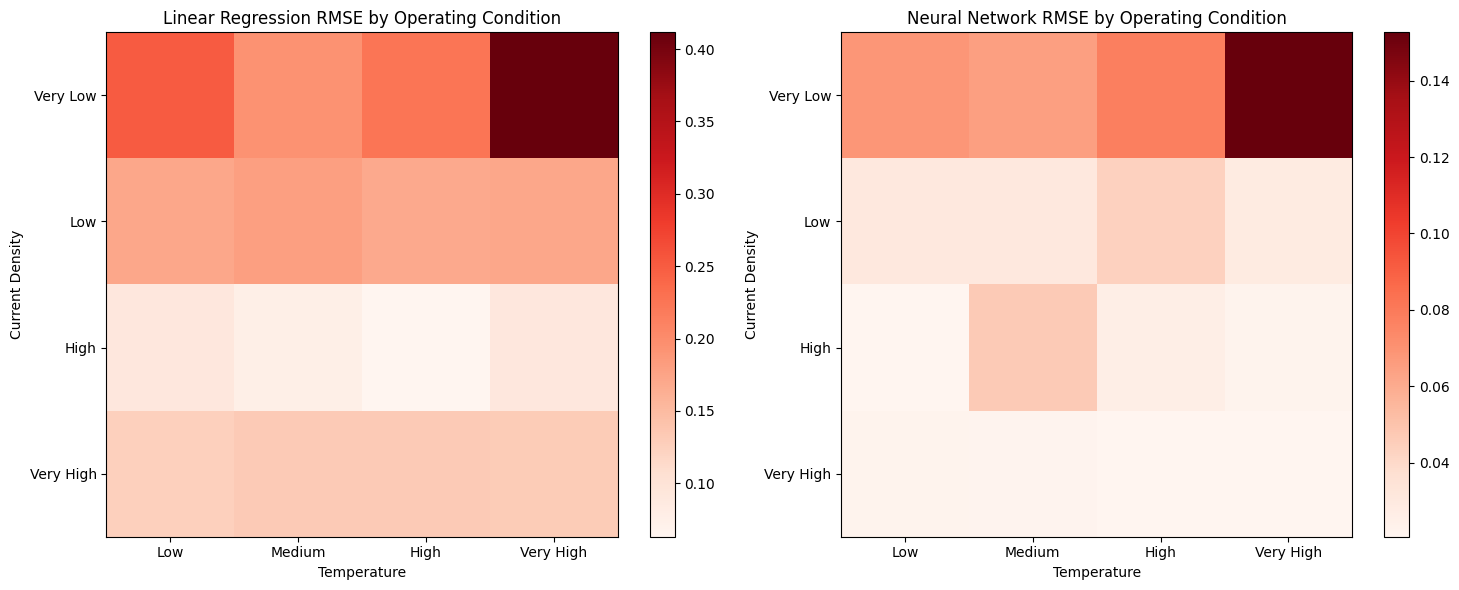

Error Pattern Analysis:
Linear Regression - Mean RMSE across all conditions: 0.163064 V
Neural Network - Mean RMSE across all conditions: 0.043681 V
Improvement: 73.21%

Linear Regression performs best at: ('High', 'High') (RMSE: 0.063061 V)
Linear Regression performs worst at: ('Very Low', 'Very High') (RMSE: 0.411562 V)
Neural Network performs best at: ('Very High', 'Very High') (RMSE: 0.020616 V)
Neural Network performs worst at: ('Very Low', 'Very High') (RMSE: 0.152652 V)


In [6]:
# 5.1 Error Analysis by Operating Point
# Create a 2D grid of current density and temperature
cd_bins = pd.cut(X_test['Current_Density_A_cm2'], bins=4, labels=['Very Low', 'Low', 'High', 'Very High'])
temp_bins = pd.cut(X_test['Temperature_K'], bins=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Calculate RMSE for each combination
error_grid_lr = pd.crosstab(cd_bins, temp_bins, 
                           values=(y_test - lr_pred)**2, 
                           aggfunc=lambda x: np.sqrt(x.mean()))

error_grid_nn = pd.crosstab(cd_bins, temp_bins, 
                           values=(y_test - nn_pred)**2, 
                           aggfunc=lambda x: np.sqrt(x.mean()))

print("Linear Regression RMSE by Operating Condition:")
display(error_grid_lr)

print("\nNeural Network RMSE by Operating Condition:")
display(error_grid_nn)

# 5.2 Visualization of error patterns
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Heatmap for Linear Regression
im1 = axes[0].imshow(error_grid_lr, cmap='Reds', aspect='auto')
axes[0].set_xticks(range(len(error_grid_lr.columns)))
axes[0].set_yticks(range(len(error_grid_lr.index)))
axes[0].set_xticklabels(error_grid_lr.columns)
axes[0].set_yticklabels(error_grid_lr.index)
axes[0].set_xlabel('Temperature')
axes[0].set_ylabel('Current Density')
axes[0].set_title('Linear Regression RMSE by Operating Condition')
plt.colorbar(im1, ax=axes[0])

# Heatmap for Neural Network
im2 = axes[1].imshow(error_grid_nn, cmap='Reds', aspect='auto')
axes[1].set_xticks(range(len(error_grid_nn.columns)))
axes[1].set_yticks(range(len(error_grid_nn.index)))
axes[1].set_xticklabels(error_grid_nn.columns)
axes[1].set_yticklabels(error_grid_nn.index)
axes[1].set_xlabel('Temperature')
axes[1].set_ylabel('Current Density')
axes[1].set_title('Neural Network RMSE by Operating Condition')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

# 5.3 Statistical analysis of error patterns
print("Error Pattern Analysis:")
print(f"Linear Regression - Mean RMSE across all conditions: {error_grid_lr.values.mean():.6f} V")
print(f"Neural Network - Mean RMSE across all conditions: {error_grid_nn.values.mean():.6f} V")
print(f"Improvement: {(error_grid_lr.values.mean() - error_grid_nn.values.mean()) / error_grid_lr.values.mean() * 100:.2f}%")

# Find where each model performs best and worst
lr_min_error_condition = error_grid_lr.stack().idxmin()
lr_max_error_condition = error_grid_lr.stack().idxmax()
nn_min_error_condition = error_grid_nn.stack().idxmin()
nn_max_error_condition = error_grid_nn.stack().idxmax()

print(f"\nLinear Regression performs best at: {lr_min_error_condition} (RMSE: {error_grid_lr.loc[lr_min_error_condition]:.6f} V)")
print(f"Linear Regression performs worst at: {lr_max_error_condition} (RMSE: {error_grid_lr.loc[lr_max_error_condition]:.6f} V)")
print(f"Neural Network performs best at: {nn_min_error_condition} (RMSE: {error_grid_nn.loc[nn_min_error_condition]:.6f} V)")
print(f"Neural Network performs worst at: {nn_max_error_condition} (RMSE: {error_grid_nn.loc[nn_max_error_condition]:.6f} V)")

ANALYSIS ON UNSEEN DATA PREDICTIONS
First 10 unseen data points with predictions:


,Current_Density_A_cm2,Temperature_K,True_Voltage_V,LR_Predicted_V,NN_Predicted_V,LR_Error_V,NN_Error_V,LR_Abs_Error,NN_Abs_Error
0,1.044704,335.558156,0.875401,0.891057,0.879118,-0.015656,-0.003717,0.015656,0.003717
1,0.429209,307.006467,1.362681,1.546736,1.339858,-0.184056,0.022823,0.184056,0.022823
2,0.340277,342.201892,1.714574,1.880953,1.794341,-0.166379,-0.079766,0.166379,0.079766
3,0.826972,362.765180,1.239800,1.350219,1.263412,-0.110419,-0.023611,0.110419,0.023611
4,1.079203,349.163840,0.926563,0.927422,0.923017,-0.000859,0.003545,0.000859,0.003545
5,0.634660,337.426447,1.286681,1.455097,1.296238,-0.168417,-0.009557,0.168417,0.009557
6,1.471146,309.158116,0.353271,0.155507,0.337039,0.197764,0.016233,0.197764,0.016233
7,1.027245,344.990044,0.947528,0.972032,0.942960,-0.024504,0.004568,0.024504,0.004568
8,0.721398,342.670072,1.224982,1.370126,1.202731,-0.145145,0.022251,0.145145,0.022251
9,0.588176,305.945828,1.150809,1.326019,1.165490,-0.175210,-0.014681,0.175210,0.014681



OVERALL PERFORMANCE ON UNSEEN DATA
Performance Comparison: Training vs Unseen Data


,Model,MSE,RMSE,MAE,R²,Relative RMSE (%),Relative MAE (%)
0,Linear Regression (Test),0.035473,0.188342,0.139561,0.908565,14.953035,11.080132
1,Neural Network (Test),0.003344,0.057825,0.032803,0.991381,4.590924,2.604292
2,Linear Regression (Unseen),0.043334,0.208169,0.133464,0.869530,16.821191,10.784656
3,Neural Network (Unseen),0.006236,0.078967,0.027300,0.981225,6.380985,2.205970


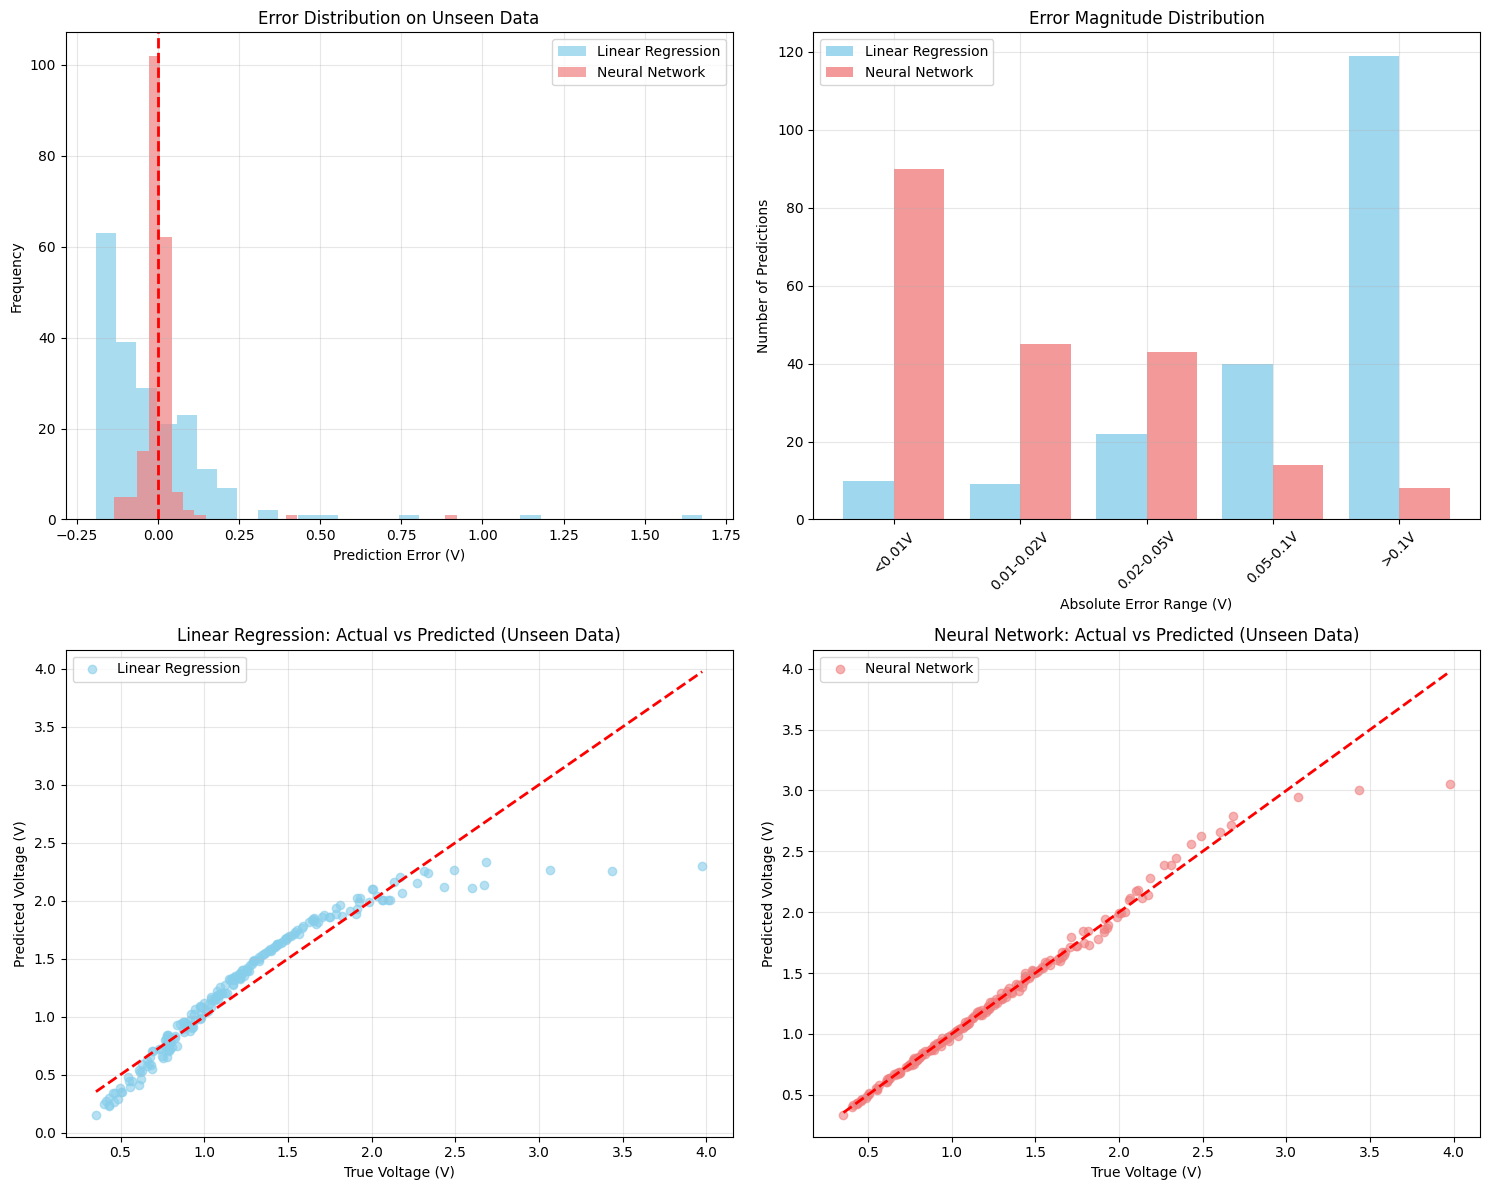


PERFORMANCE ACROSS OPERATING REGIONS (UNSEEN DATA)
Performance by Operating Region:


C:\Users\Maintenant prêt\AppData\Local\Temp\ipykernel_15396\2717637540.py:197: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  region_performance = unseen_df.groupby('Operating_Region').apply(


,LR_RMSE,NN_RMSE,LR_MAE,NN_MAE,Sample_Count
Operating_Region,,,,,
Activation Region,0.414022,0.186937,0.221220,0.095272,34.0
Concentration Region,0.099167,0.008352,0.076376,0.006419,63.0
Ohmic Region,0.146785,0.023029,0.139414,0.017634,103.0



STATISTICAL SIGNIFICANCE TESTS
Paired t-test for absolute errors:
t-statistic: 14.1141, p-value: 8.4153e-32
The difference in absolute errors is statistically significant (p < 0.05)

Wilcoxon signed-rank test:
statistic: 369.0000, p-value: 3.3654e-32

ERROR ANALYSIS BY PARAMETER RANGES
Error Analysis by Current Density Range:


C:\Users\Maintenant prêt\AppData\Local\Temp\ipykernel_15396\2717637540.py:240: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cd_error_analysis = unseen_df.groupby('CD_Bin').apply(
C:\Users\Maintenant prêt\AppData\Local\Temp\ipykernel_15396\2717637540.py:240: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cd_error_analysis = unseen_df.groupby('CD_Bin').apply(


,LR_Mean_Error,NN_Mean_Error,LR_Std_Error,NN_Std_Error,Count
CD_Bin,,,,,
"(0.00254, 0.302]",0.148508,0.028960,0.392282,0.187457,34.0
"(0.302, 0.6]",-0.179822,-0.008570,0.011651,0.028617,42.0
"(0.6, 0.897]",-0.127684,0.003777,0.029375,0.018044,47.0
"(0.897, 1.195]",-0.017926,0.000401,0.034356,0.010304,43.0
"(1.195, 1.493]",0.125723,0.000985,0.045509,0.008193,34.0



Error Analysis by Temperature Range:


C:\Users\Maintenant prêt\AppData\Local\Temp\ipykernel_15396\2717637540.py:254: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_error_analysis = unseen_df.groupby('Temp_Bin').apply(
C:\Users\Maintenant prêt\AppData\Local\Temp\ipykernel_15396\2717637540.py:254: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_error_analysis = unseen_df.groupby('Temp_Bin').apply(


,LR_Mean_Error,NN_Mean_Error,LR_Std_Error,NN_Std_Error,Count
Temp_Bin,,,,,
"(303.152, 315.123]",-0.041973,0.005172,0.111630,0.026263,37.0
"(315.123, 327.033]",-0.014632,-0.008803,0.168652,0.035424,50.0
"(327.033, 338.944]",0.045737,0.034217,0.381050,0.167286,38.0
"(338.944, 350.855]",-0.062256,-0.002501,0.113500,0.035650,32.0
"(350.855, 362.765]",-0.057252,-0.002755,0.122711,0.029333,43.0



WORST-CASE PREDICTION ANALYSIS
5 Worst Predictions - Linear Regression:


,Current_Density_A_cm2,Temperature_K,True_Voltage_V,LR_Predicted_V,LR_Error_V
118,0.004032,336.362085,3.976099,2.298581,1.677518
186,0.011140,331.241325,3.435834,2.257814,1.178019
74,0.024194,335.033159,3.068131,2.263313,0.804818
194,0.043980,319.210576,2.670289,2.140280,0.530009
196,0.048297,315.639158,2.601136,2.112710,0.488426



5 Worst Predictions - Neural Network:


,Current_Density_A_cm2,Temperature_K,True_Voltage_V,NN_Predicted_V,NN_Error_V
118,0.004032,336.362085,3.976099,3.055021,0.921078
186,0.011140,331.241325,3.435834,3.007830,0.428003
13,0.089517,350.291230,2.491707,2.625935,-0.134228
147,0.072869,322.625994,2.432200,2.559230,-0.127030
74,0.024194,335.033159,3.068131,2.945920,0.122211



Analysis of Worst Predictions:
Linear Regression worst errors occur at: 
  Current Density: 0.026 ± 0.020 A/cm²
  Temperature: 327.5 ± 9.5 K

Neural Network worst errors occur at: 
  Current Density: 0.040 ± 0.038 A/cm²
  Temperature: 335.1 ± 10.0 K

CONFIDENCE INTERVAL ANALYSIS
Linear Regression Error 95% CI: -0.025003 V [-0.053892, 0.003886]
Neural Network Error 95% CI: 0.004265 V [-0.006758, 0.015287]

Linear Regression CI includes zero: True
Neural Network CI includes zero: True

Unseen data analysis completed successfully!


In [13]:
# 6. Prediction Analysis on Completely Unseen Data

print("="*60)
print("ANALYSIS ON UNSEEN DATA PREDICTIONS")
print("="*60)

# First, define the polarization curve function
def polarization_curve(current_density, temperature, E0=1.2, R=0.2, alpha=0.5, beta=0.1):
    """
    Simplified polarization curve model for a fuel cell
    
    Parameters:
    -----------
    current_density : array-like
        Current density values (A/cm²)
    temperature : array-like
        Temperature values (K)
    E0 : float, optional
        Open circuit voltage (V)
    R : float, optional
        Ohmic resistance (Ω·cm²)
    alpha : float, optional
        Activation polarization parameter
    beta : float, optional
        Concentration polarization parameter
        
    Returns:
    --------
    voltage : array-like
        Calculated cell voltage (V)
    """
    # Temperature effect on performance (simplified)
    temp_effect = 1 + 0.005 * (temperature - 333)  # 333K reference temperature
    
    # Calculate voltage components
    activation_loss = alpha * np.log(current_density + 1e-10)  # Avoid log(0)
    ohmic_loss = R * current_density
    concentration_loss = beta * current_density**2
    
    # Total voltage
    voltage = E0 * temp_effect - activation_loss - ohmic_loss - concentration_loss
    
    return voltage

# 6.1 Generate completely new unseen data points
np.random.seed(123)  # Different seed from training data
n_unseen = 200
unseen_current_density = np.random.uniform(0, 1.5, n_unseen)
unseen_temperature = np.random.uniform(303, 363, n_unseen)

# Create true values using the physics model (without noise for clean comparison)
unseen_voltage_true = polarization_curve(unseen_current_density, unseen_temperature)

# Create DataFrame for unseen data
unseen_df = pd.DataFrame({
    'Current_Density_A_cm2': unseen_current_density,
    'Temperature_K': unseen_temperature,
    'True_Voltage_V': unseen_voltage_true
})

# 6.2 Make predictions on unseen data
unseen_X = unseen_df[['Current_Density_A_cm2', 'Temperature_K']]
unseen_X_scaled = scaler.transform(unseen_X)

unseen_df['LR_Predicted_V'] = lr_model.predict(unseen_X)
unseen_df['NN_Predicted_V'] = nn_model.predict(unseen_X_scaled)

# Calculate errors
unseen_df['LR_Error_V'] = unseen_df['True_Voltage_V'] - unseen_df['LR_Predicted_V']
unseen_df['NN_Error_V'] = unseen_df['True_Voltage_V'] - unseen_df['NN_Predicted_V']
unseen_df['LR_Abs_Error'] = np.abs(unseen_df['LR_Error_V'])
unseen_df['NN_Abs_Error'] = np.abs(unseen_df['NN_Error_V'])

print("First 10 unseen data points with predictions:")
display(unseen_df.head(10))

# 6.3 Overall performance on unseen data
print("\n" + "="*50)
print("OVERALL PERFORMANCE ON UNSEEN DATA")
print("="*50)

# Define the calculate_metrics function if not already defined
def calculate_metrics(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Calculate relative errors
    relative_rmse = rmse / np.mean(y_true) * 100
    relative_mae = mae / np.mean(y_true) * 100
    
    return {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'Relative RMSE (%)': relative_rmse,
        'Relative MAE (%)': relative_mae
    }

lr_unseen_metrics = calculate_metrics(unseen_df['True_Voltage_V'], unseen_df['LR_Predicted_V'], 'Linear Regression (Unseen)')
nn_unseen_metrics = calculate_metrics(unseen_df['True_Voltage_V'], unseen_df['NN_Predicted_V'], 'Neural Network (Unseen)')

# Add training performance for comparison
lr_train_metrics = calculate_metrics(y_test, lr_pred, 'Linear Regression (Test)')
nn_train_metrics = calculate_metrics(y_test, nn_pred, 'Neural Network (Test)')

comparison_df = pd.DataFrame([lr_train_metrics, nn_train_metrics, lr_unseen_metrics, nn_unseen_metrics])
print("Performance Comparison: Training vs Unseen Data")
display(comparison_df)

# 6.4 Error distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Error histograms
axes[0, 0].hist(unseen_df['LR_Error_V'], bins=30, alpha=0.7, color='skyblue', label='Linear Regression')
axes[0, 0].hist(unseen_df['NN_Error_V'], bins=30, alpha=0.7, color='lightcoral', label='Neural Network')
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Prediction Error (V)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Error Distribution on Unseen Data')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Absolute error comparison
error_categories = ['<0.01V', '0.01-0.02V', '0.02-0.05V', '0.05-0.1V', '>0.1V']
lr_error_counts = [
    (unseen_df['LR_Abs_Error'] < 0.01).sum(),
    ((unseen_df['LR_Abs_Error'] >= 0.01) & (unseen_df['LR_Abs_Error'] < 0.02)).sum(),
    ((unseen_df['LR_Abs_Error'] >= 0.02) & (unseen_df['LR_Abs_Error'] < 0.05)).sum(),
    ((unseen_df['LR_Abs_Error'] >= 0.05) & (unseen_df['LR_Abs_Error'] < 0.1)).sum(),
    (unseen_df['LR_Abs_Error'] >= 0.1).sum()
]

nn_error_counts = [
    (unseen_df['NN_Abs_Error'] < 0.01).sum(),
    ((unseen_df['NN_Abs_Error'] >= 0.01) & (unseen_df['NN_Abs_Error'] < 0.02)).sum(),
    ((unseen_df['NN_Abs_Error'] >= 0.02) & (unseen_df['NN_Abs_Error'] < 0.05)).sum(),
    ((unseen_df['NN_Abs_Error'] >= 0.05) & (unseen_df['NN_Abs_Error'] < 0.1)).sum(),
    (unseen_df['NN_Abs_Error'] >= 0.1).sum()
]

x_pos = np.arange(len(error_categories))
axes[0, 1].bar(x_pos - 0.2, lr_error_counts, 0.4, label='Linear Regression', alpha=0.8, color='skyblue')
axes[0, 1].bar(x_pos + 0.2, nn_error_counts, 0.4, label='Neural Network', alpha=0.8, color='lightcoral')
axes[0, 1].set_xlabel('Absolute Error Range (V)')
axes[0, 1].set_ylabel('Number of Predictions')
axes[0, 1].set_title('Error Magnitude Distribution')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(error_categories, rotation=45)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Actual vs Predicted for both models
axes[1, 0].scatter(unseen_df['True_Voltage_V'], unseen_df['LR_Predicted_V'], alpha=0.6, label='Linear Regression', color='skyblue')
axes[1, 0].plot([unseen_df['True_Voltage_V'].min(), unseen_df['True_Voltage_V'].max()], 
                [unseen_df['True_Voltage_V'].min(), unseen_df['True_Voltage_V'].max()], 
                'r--', linewidth=2)
axes[1, 0].set_xlabel('True Voltage (V)')
axes[1, 0].set_ylabel('Predicted Voltage (V)')
axes[1, 0].set_title('Linear Regression: Actual vs Predicted (Unseen Data)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(unseen_df['True_Voltage_V'], unseen_df['NN_Predicted_V'], alpha=0.6, label='Neural Network', color='lightcoral')
axes[1, 1].plot([unseen_df['True_Voltage_V'].min(), unseen_df['True_Voltage_V'].max()], 
                [unseen_df['True_Voltage_V'].min(), unseen_df['True_Voltage_V'].max()], 
                'r--', linewidth=2)
axes[1, 1].set_xlabel('True Voltage (V)')
axes[1, 1].set_ylabel('Predicted Voltage (V)')
axes[1, 1].set_title('Neural Network: Actual vs Predicted (Unseen Data)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6.5 Performance across different operating regions
print("\n" + "="*50)
print("PERFORMANCE ACROSS OPERATING REGIONS (UNSEEN DATA)")
print("="*50)

# Define operating regions based on current density
def categorize_region(current_density):
    if current_density < 0.3:
        return 'Activation Region'
    elif current_density < 1.0:
        return 'Ohmic Region'
    else:
        return 'Concentration Region'

unseen_df['Operating_Region'] = unseen_df['Current_Density_A_cm2'].apply(categorize_region)

# Calculate performance by region
region_performance = unseen_df.groupby('Operating_Region').apply(
    lambda x: pd.Series({
        'LR_RMSE': np.sqrt(((x['True_Voltage_V'] - x['LR_Predicted_V']) ** 2).mean()),
        'NN_RMSE': np.sqrt(((x['True_Voltage_V'] - x['NN_Predicted_V']) ** 2).mean()),
        'LR_MAE': (np.abs(x['True_Voltage_V'] - x['LR_Predicted_V'])).mean(),
        'NN_MAE': (np.abs(x['True_Voltage_V'] - x['NN_Predicted_V'])).mean(),
        'Sample_Count': len(x)
    })
)

print("Performance by Operating Region:")
display(region_performance)

# 6.6 Statistical significance tests
print("\n" + "="*50)
print("STATISTICAL SIGNIFICANCE TESTS")
print("="*50)

# Paired t-test for errors
t_stat, p_value = stats.ttest_rel(unseen_df['LR_Abs_Error'], unseen_df['NN_Abs_Error'])
print(f"Paired t-test for absolute errors:")
print(f"t-statistic: {t_stat:.4f}, p-value: {p_value:.4e}")

if p_value < 0.05:
    print("The difference in absolute errors is statistically significant (p < 0.05)")
else:
    print("The difference in absolute errors is not statistically significant (p >= 0.05)")

# Wilcoxon signed-rank test (non-parametric alternative)
w_stat, w_p_value = stats.wilcoxon(unseen_df['LR_Abs_Error'], unseen_df['NN_Abs_Error'])
print(f"\nWilcoxon signed-rank test:")
print(f"statistic: {w_stat:.4f}, p-value: {w_p_value:.4e}")

# 6.7 Error analysis by temperature and current density ranges
print("\n" + "="*50)
print("ERROR ANALYSIS BY PARAMETER RANGES")
print("="*50)

# Create bins for analysis
unseen_df['CD_Bin'] = pd.cut(unseen_df['Current_Density_A_cm2'], bins=5)
unseen_df['Temp_Bin'] = pd.cut(unseen_df['Temperature_K'], bins=5)

# Analyze errors by current density
cd_error_analysis = unseen_df.groupby('CD_Bin').apply(
    lambda x: pd.Series({
        'LR_Mean_Error': x['LR_Error_V'].mean(),
        'NN_Mean_Error': x['NN_Error_V'].mean(),
        'LR_Std_Error': x['LR_Error_V'].std(),
        'NN_Std_Error': x['NN_Error_V'].std(),
        'Count': len(x)
    })
)

print("Error Analysis by Current Density Range:")
display(cd_error_analysis)

# Analyze errors by temperature
temp_error_analysis = unseen_df.groupby('Temp_Bin').apply(
    lambda x: pd.Series({
        'LR_Mean_Error': x['LR_Error_V'].mean(),
        'NN_Mean_Error': x['NN_Error_V'].mean(),
        'LR_Std_Error': x['LR_Error_V'].std(),
        'NN_Std_Error': x['NN_Error_V'].std(),
        'Count': len(x)
    })
)

print("\nError Analysis by Temperature Range:")
display(temp_error_analysis)

# 6.8 Worst-case analysis
print("\n" + "="*50)
print("WORST-CASE PREDICTION ANALYSIS")
print("="*50)

# Find the 5 worst predictions for each model
lr_worst = unseen_df.nlargest(5, 'LR_Abs_Error')[['Current_Density_A_cm2', 'Temperature_K', 
                                                  'True_Voltage_V', 'LR_Predicted_V', 'LR_Error_V']]
nn_worst = unseen_df.nlargest(5, 'NN_Abs_Error')[['Current_Density_A_cm2', 'Temperature_K', 
                                                  'True_Voltage_V', 'NN_Predicted_V', 'NN_Error_V']]

print("5 Worst Predictions - Linear Regression:")
display(lr_worst)

print("\n5 Worst Predictions - Neural Network:")
display(nn_worst)

# Analyze patterns in worst predictions
print("\nAnalysis of Worst Predictions:")
print(f"Linear Regression worst errors occur at: ")
print(f"  Current Density: {lr_worst['Current_Density_A_cm2'].mean():.3f} ± {lr_worst['Current_Density_A_cm2'].std():.3f} A/cm²")
print(f"  Temperature: {lr_worst['Temperature_K'].mean():.1f} ± {lr_worst['Temperature_K'].std():.1f} K")

print(f"\nNeural Network worst errors occur at: ")
print(f"  Current Density: {nn_worst['Current_Density_A_cm2'].mean():.3f} ± {nn_worst['Current_Density_A_cm2'].std():.3f} A/cm²")
print(f"  Temperature: {nn_worst['Temperature_K'].mean():.1f} ± {nn_worst['Temperature_K'].std():.1f} K")

# 6.9 Confidence interval analysis
print("\n" + "="*50)
print("CONFIDENCE INTERVAL ANALYSIS")
print("="*50)

# Calculate 95% confidence intervals for the mean error
def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    std_err = stats.sem(data)
    h = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)
    return mean, mean - h, mean + h

lr_mean, lr_lower, lr_upper = confidence_interval(unseen_df['LR_Error_V'])
nn_mean, nn_lower, nn_upper = confidence_interval(unseen_df['NN_Error_V'])

print(f"Linear Regression Error 95% CI: {lr_mean:.6f} V [{lr_lower:.6f}, {lr_upper:.6f}]")
print(f"Neural Network Error 95% CI: {nn_mean:.6f} V [{nn_lower:.6f}, {nn_upper:.6f}]")

# Check if confidence intervals include zero
print(f"\nLinear Regression CI includes zero: {lr_lower <= 0 <= lr_upper}")
print(f"Neural Network CI includes zero: {nn_lower <= 0 <= nn_upper}")

print("\nUnseen data analysis completed successfully!")